# Batch UCB


In [1]:
# direct to proper path
import os
import sys
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from collections import defaultdict
import math
import json

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import PairwiseKernel, DotProduct, RBF 
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import r2_score, mean_squared_error, make_scorer
from sklearn.model_selection import KFold
from sklearn_extra.cluster import KMedoids

from codes.embedding import Embedding
from codes.environment import Rewards_env
from codes.ucb import GPUCB, Random
from codes.evaluations import evaluate, plot_eva
from codes.regression import *
from codes.kernels_for_GPK import *
from codes.batch_ucb import *

from ipywidgets import IntProgress
from IPython.display import display
import warnings
%matplotlib inline

**Update 13/Nov/2020** Generate recommendation for round 2 (with partial replicates for round 0 and 1)

In [2]:
norm_method = 'mean'
log_flag = 'True'
Path = '../../data/Results_Microplate_partialTrue_normTrue_' + norm_method+ '_roundRep_formatSeq_log' + log_flag + '.csv'

known_df = pd.read_csv(Path)
known_df.head()

,idx,RBS,Name,Rep1,Rep2,Rep3,Rep4,Rep5,Rep6,AVERAGE,...,Round,Rep7,Rep8,Rep9,Unnamed: 19,Unnamed: 20,RBS6,Pred Mean,Pred Std,Pred UCB
0,648.0,TTTAAGAAGGAGATATACAT,RBS_1by1_0,2.482263,2.555338,2.358414,3.102950,2.999178,2.316265,2.635735,...,0,NaN,NaN,NaN,NaN,NaN,AGGAGA,NaN,NaN,NaN
1,4096.0,CTTAAGAAGGAGATATACAT,RBS_1by1_1,1.592779,1.694296,1.798210,1.850738,2.381356,1.996343,1.885620,...,0,NaN,NaN,NaN,NaN,NaN,AGGAGA,NaN,NaN,NaN
2,4097.0,GTTAAGAAGGAGATATACAT,RBS_1by1_2,0.626302,0.774704,0.947196,0.418233,0.532036,0.733023,0.671916,...,0,NaN,NaN,NaN,NaN,NaN,AGGAGA,NaN,NaN,NaN
3,4098.0,ATTAAGAAGGAGATATACAT,RBS_1by1_3,1.696364,1.917735,1.568130,1.600853,1.803056,1.260720,1.641143,...,0,NaN,NaN,NaN,NaN,NaN,AGGAGA,NaN,NaN,NaN
4,4099.0,TCTAAGAAGGAGATATACAT,RBS_1by1_4,1.582321,2.118618,1.417531,2.014216,1.831391,2.186262,1.858390,...,0,NaN,NaN,NaN,NaN,NaN,AGGAGA,NaN,NaN,NaN


In [3]:
# known_df = known_df[known_df['Group'] != 'bps_noncore']
# known_df.reset_index(inplace=True, drop=True)
# known_df['RBS'] = known_df['RBS6']
# known_df

## Conclusion of pipeline

- Data pre-processing: run codes/data_generating.py
    - log transform 
    - z-score normalisation for each replicate (zero mean and unit variance)
- Kernel: codes/kernels_for_GPK.py
    - weighted degree kernel with shift
    - normalisation: centering; unit variance; normalisation over the whole (train + test) kernel
    - l = 6 (maximum substring length)
    - s = 1 (shift)
    - sigma0 = 1 (signal std)
- Regression: codes/regression.py
    - Gaussian Process Regression
    - train on samples (multi-label) from first round result, i.e. train shape:  (1055, 20)
    - predict on all design space (4 * 6) except known sequences, i.e. test shape:  (3961, 20)
    - alpha = 2
- Recommendation: codes/batch_ucb.py
    - batch UCB (GP-BUCB)
    - beta = 2
    - recommendation size = 90

In [4]:
rec_size = 90
l = 6
s = 1
beta = 1
alpha = 2
sigma_0 = 1
kernel_name = 'WD_Kernel_Shift'
embedding = 'label'
kernel_norm_flag = True
centering_flag = True
unit_norm_flag = True

## Top n recommendations

return seuqneces with top n ucb score. 

In [5]:
top_n = Top_n_ucb(known_df, kernel_name=kernel_name, l=l, s=s, sigma_0=sigma_0,
                 embedding=embedding, alpha=alpha, rec_size=rec_size, beta=beta, 
                 kernel_norm_flag=kernel_norm_flag, centering_flag = centering_flag, unit_norm_flag=unit_norm_flag)

In [6]:
unknown_df = top_n.generate_design_space()
# unknown_df.to_csv('unknown_df.csv')
unknown_df.shape

(3783, 2)

In [7]:
top_n_rec_df = top_n.run_experiment()

X train shape:  (2147, 20)
X test shape:  (3783, 20)
create kernel instance
wds_l6_sigma0_1_s1_center_True_unitnorm_True
Load saved kernel matrix...
finish creating kernel instance
gp_reg fit
wds_l6_sigma0_1_s1_center_True_unitnorm_True
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_True_unitnorm_True
Load saved kernel matrix...
gp_reg pred
finish reg


(array([  8.,  25.,  94., 252., 438., 709., 885., 783., 485., 104.]),
 array([0.35336821, 0.38860049, 0.42383278, 0.45906506, 0.49429735,
        0.52952963, 0.56476191, 0.5999942 , 0.63522648, 0.67045877,
        0.70569105]),
 <BarContainer object of 10 artists>)

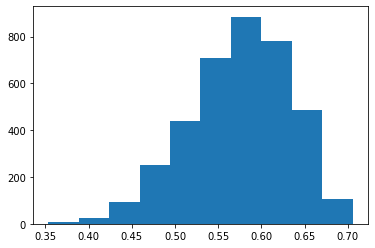

In [8]:
plt.hist(top_n.df_design['pred std'])

(array([ 2.,  0.,  4., 14.,  8.,  8., 13., 13., 15., 13.]),
 array([0.35336821, 0.38826183, 0.42315545, 0.45804908, 0.4929427 ,
        0.52783632, 0.56272994, 0.59762356, 0.63251719, 0.66741081,
        0.70230443]),
 <BarContainer object of 10 artists>)

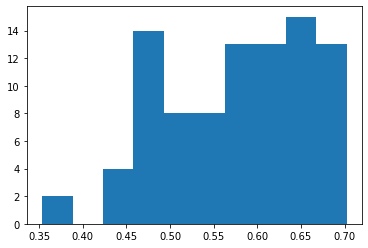

In [9]:
plt.hist(top_n_rec_df['pred std'])

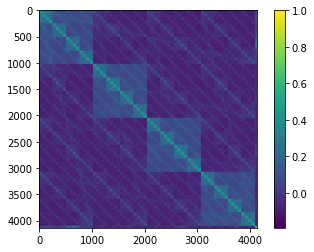

In [10]:
kernel_matrix = top_n.gpr.wd_kernel_instance.kernel_all_normalised
plt.imshow(kernel_matrix)
plt.colorbar()

## GP-BUCB

Desautels et al. 2014 Algorithm 2
http://jmlr.org/papers/volume15/desautels14a/desautels14a.pdf

In [11]:
gpbucb = GP_BUCB(known_df, kernel_name=kernel_name, l=l, s=s,sigma_0=sigma_0,
                 embedding=embedding, alpha=alpha, rec_size=rec_size, beta=beta, 
                 kernel_norm_flag=kernel_norm_flag, centering_flag = centering_flag, unit_norm_flag=unit_norm_flag)

In [12]:
gpbucb_rec_df = gpbucb.run_experiment()

0_1_s1_center_True_unitnorm_True
Load saved kernel matrix...
gp_reg pred
finish reg
train size  (397, 28)
X train shape:  (2186, 20)
X test shape:  (3744, 20)
create kernel instance
wds_l6_sigma0_1_s1_center_True_unitnorm_True
Load saved kernel matrix...
finish creating kernel instance
gp_reg fit
wds_l6_sigma0_1_s1_center_True_unitnorm_True
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_True_unitnorm_True
Load saved kernel matrix...
gp_reg pred
finish reg
train size  (398, 28)
X train shape:  (2187, 20)
X test shape:  (3743, 20)
create kernel instance
wds_l6_sigma0_1_s1_center_True_unitnorm_True
Load saved kernel matrix...
finish creating kernel instance
gp_reg fit
wds_l6_sigma0_1_s1_center_True_unitnorm_True
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_True_unitnorm_True
Load saved kernel matrix...
gp_reg pred
finish reg
train size  (399, 28)
X train shape:  (2188, 20)
X test shape:  (3742, 20)
create kernel instance
wds_l6_sigma0_1_s1_center_True_unitnorm_True
Load sa

## Recommendation results

In [13]:
gpbucb_rec_df

,index,AVERAGE,Group,Name,PERC,Plate,Pred Mean,Pred Std,Pred UCB,RBS,...,STD,Unnamed: 19,Unnamed: 20,Usable,idx,train_test,label,pred mean,pred std,ucb
0,1288,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TTTAAGAGGGGGCTATACAT,...,NaN,NaN,NaN,NaN,NaN,Test,NaN,1.051928,0.486657,1.538586
1,2935,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TTTAAGATAGTGGTATACAT,...,NaN,NaN,NaN,NaN,NaN,Test,NaN,0.985374,0.474414,1.459788
2,79,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TTTAAGAAAGGAGTATACAT,...,NaN,NaN,NaN,NaN,NaN,Test,NaN,0.989109,0.455412,1.444521
3,1287,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TTTAAGAGGGGACTATACAT,...,NaN,NaN,NaN,NaN,NaN,Test,NaN,1.017517,0.425414,1.442930
4,1294,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TTTAAGAGGGGTCTATACAT,...,NaN,NaN,NaN,NaN,NaN,Test,NaN,0.856143,0.532044,1.388186
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,1214,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TTTAAGAGATTACTATACAT,...,NaN,NaN,NaN,NaN,NaN,Test,NaN,0.513556,0.588211,1.101766
86,554,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TTTAAGAACGAGGTATACAT,...,NaN,NaN,NaN,NaN,NaN,Test,NaN,0.700995,0.396395,1.097390
87,117,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TTTAAGAAAGTCGTATACAT,...,NaN,NaN,NaN,NaN,NaN,Test,NaN,0.549685,0.546724,1.096409
88,40,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TTTAAGAAAACCGTATACAT,...,NaN,NaN,NaN,NaN,NaN,Test,NaN,0.529877,0.565606,1.095483


In [14]:
top_n_rec_df

,index,AVERAGE,Group,Name,PERC,Plate,Pred Mean,Pred Std,Pred UCB,RBS,...,STD,Unnamed: 19,Unnamed: 20,Usable,idx,train_test,label,pred mean,pred std,ucb
1646,1288,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TTTAAGAGGGGGCTATACAT,...,NaN,NaN,NaN,NaN,NaN,Test,NaN,1.051928,0.486657,1.538586
3293,2935,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TTTAAGATAGTGGTATACAT,...,NaN,NaN,NaN,NaN,NaN,Test,NaN,0.985374,0.474414,1.459788
437,79,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TTTAAGAAAGGAGTATACAT,...,NaN,NaN,NaN,NaN,NaN,Test,NaN,0.989109,0.455473,1.444582
1645,1287,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TTTAAGAGGGGACTATACAT,...,NaN,NaN,NaN,NaN,NaN,Test,NaN,1.017517,0.425958,1.443475
1652,1294,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TTTAAGAGGGGTCTATACAT,...,NaN,NaN,NaN,NaN,NaN,Test,NaN,0.856143,0.533390,1.389533
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2213,1855,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TTTAAGAGTTCGCTATACAT,...,NaN,NaN,NaN,NaN,NaN,Test,NaN,0.488053,0.654860,1.142914
359,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TTTAAGAAAAAAGTATACAT,...,NaN,NaN,NaN,NaN,NaN,Test,NaN,0.487834,0.654474,1.142308
403,45,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TTTAAGAAAACTCTATACAT,...,NaN,NaN,NaN,NaN,NaN,Test,NaN,0.479060,0.663122,1.142183
1844,1486,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TTTAAGAGCGAGATATACAT,...,NaN,NaN,NaN,NaN,NaN,Test,NaN,0.756452,0.385052,1.141504


In [15]:
top_n_rec_df.index

Int64Index([1646, 3293,  437, 1645, 1652, 1696,  471,  395,  407, 1452, 1704,
            1701, 1700, 1080, 3261, 1644,  771, 1650, 1078,  438, 1778,  396,
            1702, 1716, 1674, 1088, 3298,  739, 1647, 1777,  371,  582, 1649,
            1418,  370, 3294,  405, 1087,  389, 1695,  408, 1651, 1768, 1406,
            1770, 1773, 3260,  394,  476, 1648,  373,  410,  773, 3297, 1774,
             360,  436, 1068,  368, 2771,  594,  400, 1679, 3161,  592, 1457,
             398,  602, 1081,  372,  750,  363,  738, 1316,  924,  402,  747,
            1512,  746, 2545,  392,  411,  475,  472,  583, 2213,  359,  403,
            1844,  417],
           dtype='int64')

### Similarity between recommendations

characterized by the same kernel used for prediction.

Text(0.5, 1.0, 'GP_BUCB hist')

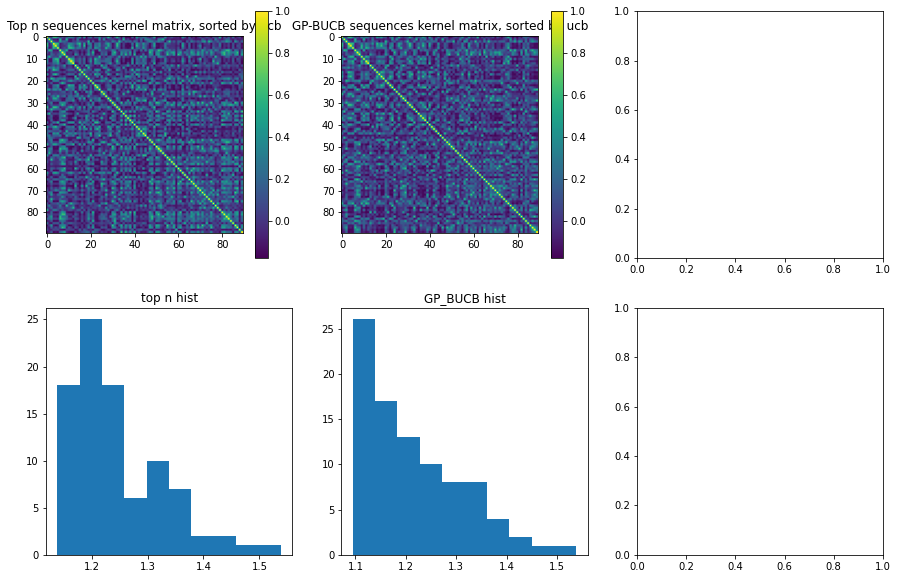

In [16]:
num_rows = 2
num_cols = 3

wd_kernel = WD_Shift_Kernel
fig,a = plt.subplots(num_rows, num_cols, figsize = (15,10))

wd_kernel.INIT_FLAG = False
im = a[0][0].imshow(top_n.gpr.wd_kernel_instance.__call__(np.asarray(top_n_rec_df['RBS'])), cmap = 'viridis')
fig.colorbar(im, ax =a[0][0])
a[0][0].set_title('Top n sequences kernel matrix, sorted by ucb')

wd_kernel.INIT_FLAG = False
im = a[0][1].imshow(gpbucb.gpr.wd_kernel_instance.__call__(np.asarray(gpbucb_rec_df['RBS'])), cmap = 'viridis')
fig.colorbar(im, ax =a[0][1])
a[0][1].set_title('GP-BUCB sequences kernel matrix, sorted by ucb')

# wd_kernel.INIT_FLAG = False
# all_features = np.concatenate((np.asarray(top_n_rec_df['RBS']), np.asarray(gpbucb_rec_df['RBS'])), axis = 0)
# im = a[0][2].imshow(wd_kernel(l=6, features = all_features).kernel_all_normalised, cmap = 'viridis')
# fig.colorbar(im, ax =a[0][2])
# a[0][2].set_title('Top n + GP-BUCB')

im = a[1][0].hist(top_n_rec_df['ucb'])
a[1][0].set_title('top n hist')

im = a[1][1].hist(gpbucb_rec_df['ucb'])
a[1][1].set_title('GP_BUCB hist')

# im = a[1][2].hist(gpbucb_rec_df['ucb'])
# a[1][2].set_title('GP_BUCB hist')

In [17]:
common_rec = set(top_n_rec_df['RBS']).intersection(set(gpbucb_rec_df['RBS']))
print('Number of intersection of recommendations: ', len(common_rec))

Number of intersection of recommendations:  82


In [18]:
para_name = 'alpha' + str(alpha) + '_beta' + str(beta) 
#+ 'kernelNorm' + str(kernel_norm_flag)

with pd.ExcelWriter('batch_ucb.xlsx', engine="openpyxl", mode='a') as writer:
    top_n_rec_df.to_excel(writer, sheet_name = 'top_n_core_' + para_name)
    gpbucb_rec_df.to_excel(writer, sheet_name = 'gpbucb_core_' + para_name)